In [1]:
# Imports
import torch
import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import os    
import torch.nn.functional as F

In [2]:
pwd

'C:\\Users\\rashe\\Documents\\PyTorch_Fund'

In [3]:
# Download training dataset
dataset = MNIST(root='data/', download=False)
len(dataset)

60000

In [4]:
test_dataset = MNIST(root='data/', train=False)
len(test_dataset)

10000

3


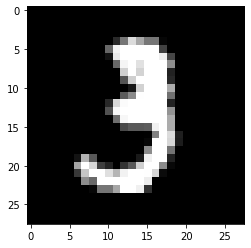

In [5]:
import matplotlib.pyplot as plt
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


img, lab = dataset[10]
plt.imshow(img, cmap='gray')
print(lab)

3


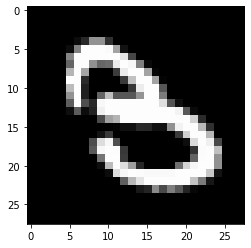

In [6]:

img, lab = test_dataset[18]
plt.imshow(img, cmap='gray')
print(lab)

In [11]:

train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

In [7]:
# MNIST dataset (images and labels) convert to tensors
dataset = MNIST(root='data/', 
                train=True,
                transform=transforms.ToTensor())

In [8]:
# convert to tensors
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=transforms.ToTensor())

In [12]:

input_size = 28*28
num_classes = 10

batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

In [13]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

In [15]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

In [16]:
for images, labels in train_loader:
    print(images.shape)
    outputs = model(images)
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

torch.Size([128, 1, 28, 28])
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.1815, -0.2995, -0.5314,  0.0320,  0.0724, -0.2923,  0.1033, -0.0103,
         -0.1401, -0.0905],
        [ 0.2842, -0.2214, -0.5031, -0.1004,  0.1375, -0.3031,  0.4183,  0.1377,
         -0.1003, -0.0797]])


In [17]:
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [18]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

#def evaluate(model, train_loader):
 #   outputs = [model.validation_step(batch) for batch in val_loader]
  #  return model.validation_epoch_end(outputs)

In [19]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [20]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [21]:
history1 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9579, val_acc: 0.5941
Epoch [1], val_loss: 1.6876, val_acc: 0.7204
Epoch [2], val_loss: 1.4852, val_acc: 0.7597
Epoch [3], val_loss: 1.3319, val_acc: 0.7807
Epoch [4], val_loss: 1.2141, val_acc: 0.7954


In [22]:
#Can we train for a few more epochs....note the training is not starting all overbut continuing from where it stopped
history2 = fit(10, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.1214, val_acc: 0.8062
Epoch [1], val_loss: 1.0470, val_acc: 0.8154
Epoch [2], val_loss: 0.9861, val_acc: 0.8219
Epoch [3], val_loss: 0.9354, val_acc: 0.8271
Epoch [4], val_loss: 0.8926, val_acc: 0.8321
Epoch [5], val_loss: 0.8559, val_acc: 0.8362
Epoch [6], val_loss: 0.8241, val_acc: 0.8397
Epoch [7], val_loss: 0.7963, val_acc: 0.8426
Epoch [8], val_loss: 0.7717, val_acc: 0.8449
Epoch [9], val_loss: 0.7499, val_acc: 0.8463


In [24]:
history


[[{'val_loss': 1.957898736000061, 'val_acc': 0.5941455960273743},
  {'val_loss': 1.6876081228256226, 'val_acc': 0.7204311490058899},
  {'val_loss': 1.4851799011230469, 'val_acc': 0.7596914768218994},
  {'val_loss': 1.331910490989685, 'val_acc': 0.780656635761261},
  {'val_loss': 1.2141135931015015, 'val_acc': 0.7953916192054749},
  {'val_loss': 1.1213983297348022, 'val_acc': 0.8061708807945251},
  {'val_loss': 1.0470446348190308, 'val_acc': 0.8153678774833679},
  {'val_loss': 0.9861119985580444, 'val_acc': 0.8218947649002075},
  {'val_loss': 0.9354084134101868, 'val_acc': 0.8271360993385315},
  {'val_loss': 0.8925597667694092, 'val_acc': 0.8320807218551636},
  {'val_loss': 0.8558812141418457, 'val_acc': 0.8362341523170471},
  {'val_loss': 0.8241092562675476, 'val_acc': 0.839695394039154},
  {'val_loss': 0.7963306307792664, 'val_acc': 0.842563271522522},
  {'val_loss': 0.7717321515083313, 'val_acc': 0.844936728477478},
  {'val_loss': 0.7498586177825928, 'val_acc': 0.8463212251663208}]]

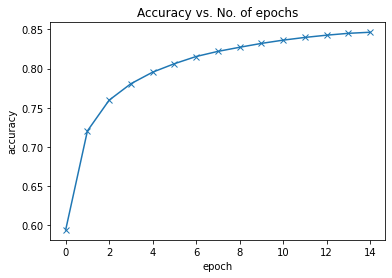

In [28]:
history = history1 + history2
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [29]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

Label: 6 , Predicted: 6


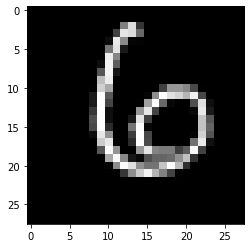

In [33]:
img, label = test_dataset[100]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 8


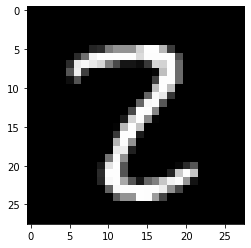

In [36]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 0 , Predicted: 0


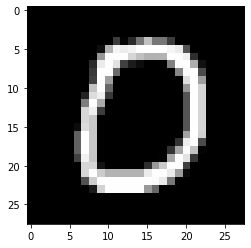

In [34]:
img, label = test_dataset[10]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 4


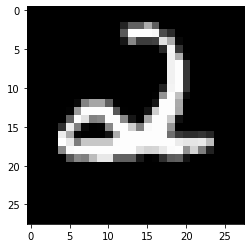

In [38]:
img, label = test_dataset[1930]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 7 , Predicted: 7


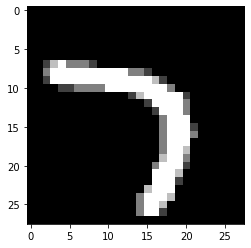

In [35]:
img, label = test_dataset[60]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))